# Polygonal Map Generation using Voronoi Maps

See Design.org for the research. Minimal description here as we develop the
idea.

First step is to recreate the [tutorial](http://docs.scipy.org/doc/scipy-0.14.0/reference/tutorial/spatial.html) on using SciPy's spatial data structures
and algorithms.

In [103]:
from scipy.spatial import Voronoi, voronoi_plot_2d, KDTree
import numpy as np
import matplotlib.pyplot as plt
import attr

%matplotlib inline
plt.rcParams['figure.figsize'] = [12.0, 8.0]

%run MapChunk.py

In [2]:
points = np.array([[0., 0.], [0., 1.], [0., 2.], [1., 0.], [1., 1.], [1., 2.],
                   [2., 0.], [2., 1.], [2., 2.]])

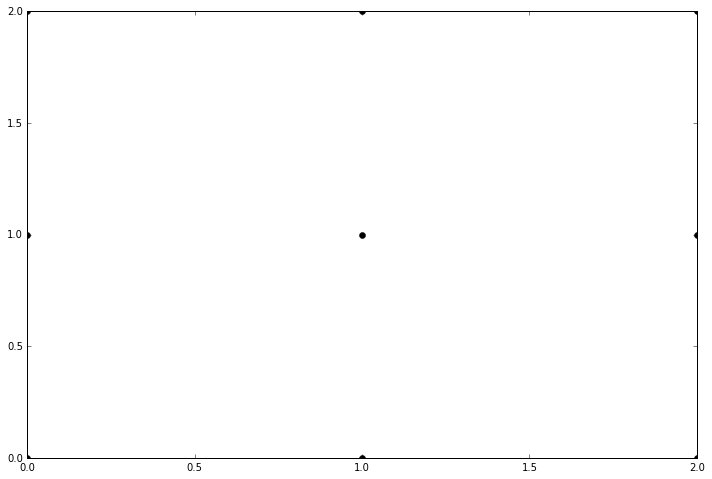

In [7]:
plt.plot(points[:,0], points[:,1], 'ko')
plt.show()

In [8]:
vor = Voronoi(points)
vor.vertices

array([[ 0.5,  0.5],
       [ 1.5,  0.5],
       [ 0.5,  1.5],
       [ 1.5,  1.5]])

In [0]:
voronoi_plot_2d(vor)

The values in `vor.regions` denote the set of points from `vor.vertices` forming
the Polygonal edges of the Voronoi regions. Negative numbers indicate points at
infinity.

In [9]:
vor.regions

[[],
 [-1, 0],
 [-1, 1],
 [1, -1, 0],
 [3, -1, 2],
 [-1, 3],
 [-1, 2],
 [3, 2, 0, 1],
 [2, -1, 0],
 [3, -1, 1]]

`vor.ridge_vertices` indicate lines in 2-D that separate the regions. Voronoi
ridges are perpendicular to lines drawn between the input points.
`vor.ridge_points` are the two points each ridge corresponds to.

In [7]:
vor.ridge_points

array([[0, 1],
       [0, 3],
       [6, 3],
       [6, 7],
       [3, 4],
       [5, 8],
       [5, 2],
       [5, 4],
       [8, 7],
       [2, 1],
       [4, 1],
       [4, 7]], dtype=int32)

In [0]:
%pwd

### Generating a Map

Grid dimensions corresponds roughly to number of points.

Grid width * grid height = Points/polygons.

In [10]:
width, height = 100, 100
seed = np.random.random((width*height, 2))

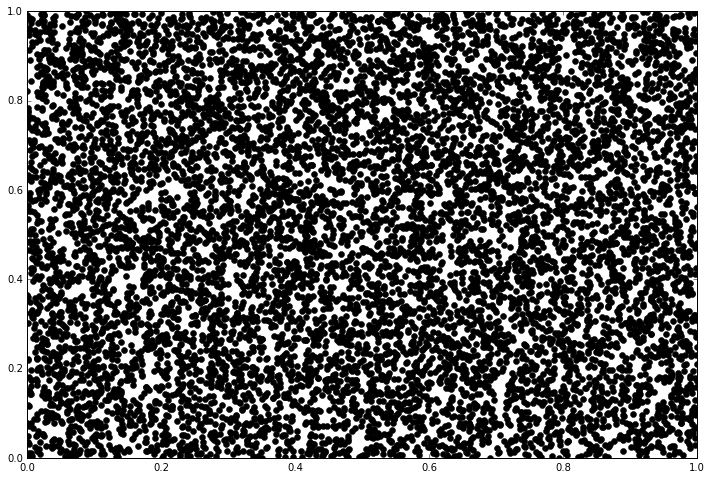

In [11]:
plt.plot(seed[:,0], seed[:,1], 'ko')

In [12]:
relaxed = relax(seed, 4)


In [13]:
polymap = Voronoi(relaxed)

Zoom in a bit to see if this is working.

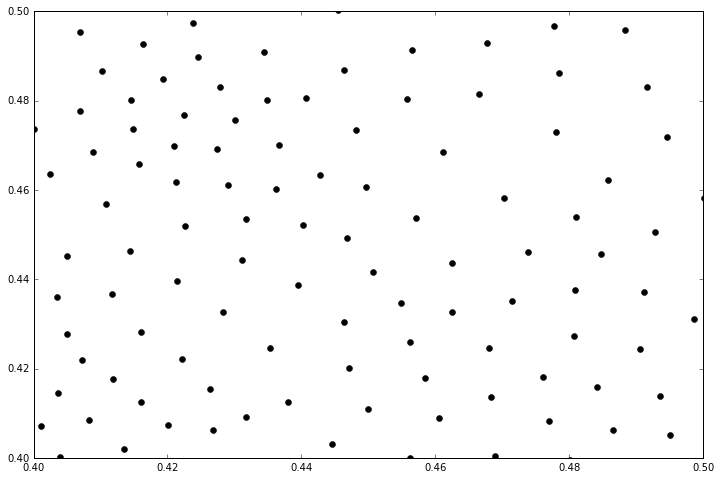

(0.4, 0.5)

In [14]:
fig = plt.plot(relaxed[:,0], relaxed[:,1], 'ko')
plt.xlim([0.4, 0.5])
plt.ylim([0.4, 0.5])

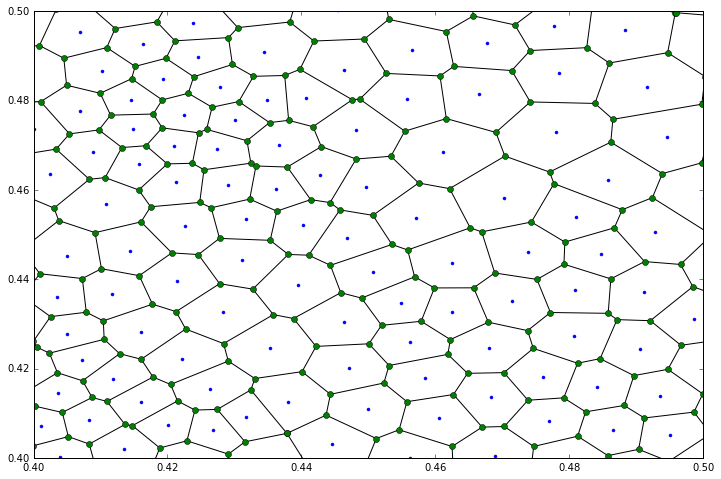

(0.4, 0.5)

In [15]:
voronoi_plot_2d(polymap)
plt.xlim([0.4, 0.5])
plt.ylim([0.4, 0.5])


In [18]:
nearest = KDTree(polymap.points)

In [22]:
nearest.query([0.983, 0.148])

(0.00062246929440689378, 0)

In [23]:
nearest.data[0]

array([ 0.98345188,  0.1484281 ])

## Map Representation

Now comes the task of storing points and polygons to a graph.

 - Voronoi.vertices gives list of vertices forming voronoi regions,

 - voronoi.ridge_vertices tells us how the vertices are connected.

 - voronoi.ridge_points are the two points on either side of a given ridge.

 - voronoi.region are the vertices that form a polygon for a given voronoi
   region.

   The relaxing algorithm will take a point and get the voronoi region for that
   point. If there are no negative indices then computing the centroid is easy.
   If not, then the question is where do(es) the infinite point(s) lay?

   The number of ridges for a region = number of edges for the polygon. Number
   of vertices for polygon == n_edges
   
   First do we find the ridge_points connected to point?

In [55]:
polymap.ridge_vertices[2]

[3, 13]

Graph is the fundamental data structure for representing the world.

In [1]:
import networkx as nx

One graph for polygons, another for polygon corner (vertex?).

Nodes are the points/vertices, but their values need to be hashable so make the
nodes the indexes of the points/vertices in the Voronoi object.

Edges are enumerated in ridge_vertices and ridge_points. ridge_points shows relationships
between points, ridge_vertices between vertices.


In [109]:
@attr.s
class PolyFeature(object):
    idx = attr.ib()
    parent = attr.ib()
    center = attr.ib()
    elevation = attr.ib(default=0.0)
    precipitation = attr.ib(default=0.0)
    temperature = attr.ib(default=0.0)
    color = attr.ib(default=0.0)


In [110]:
corners = nx.Graph()
polys = nx.Graph()
points = relax(np.random.random((100*100,2)), 4)
polymap = Voronoi(points)
dist_map = KDTree(points)

In [91]:
len(polymap.points)

10000

In [98]:
for p in range(len(polymap.points)):
    f = PolyFeature(idx=p, map=polys, center=polymap.points[p])
    polys.add_node(p, feature=f)

for rp in polymap.ridge_points:
    polys.add_edge(*rp.tolist())
    
for c in range(len(polymap.vertices)):
    corners.add_node(c)

for rv in polymap.ridge_vertices:
    corners.add_edge(*rv)

In [99]:
polys.node[1]

{'feature': PolyFeature(idx=1, map=<networkx.classes.graph.Graph object at 0x000002000B72BF28>, center=array([ 0.11013823,  0.37794295]), elevation=0.0, precipitation=0.0, temperature=0.0, color=0.0)}

In [100]:
dist_map.query([0.0, 0.0])

(0.0051608336811048653, 9575)

In [101]:
polys.node[9575]

{'feature': PolyFeature(idx=9575, map=<networkx.classes.graph.Graph object at 0x000002000B72BF28>, center=array([ 0.004239  ,  0.00294365]), elevation=0.0, precipitation=0.0, temperature=0.0, color=0.0)}

In [102]:
polymap.points[9575]

array([ 0.004239  ,  0.00294365])

## Exploration

In [120]:
%run MapChunk.py

In [121]:
map = PolygonMap()
map.generate(100)

In [123]:
map.poly_graph[0]

{34: {}, 36: {}, 40: {}, 48: {}, 52: {}, 84: {}, 97: {}}

As Amit notes, a strictly random distribution makes for irregular polygon shapes
and sizes. What one wants is semi-random "blue noise", which Amit approximates
using Lloyd Relaxation. One way to do that in 2D is calculate the
[centroid](https://en.wikipedia.org/wiki/Centroid#Centroid_of_polygon) of each
polygon.


In [11]:
def centroid(vertices):
    x = vertices[:, 0]
    y = vertices[:, 1]
    c_x, c_y, a = 0., 0., 0.
    for i in range(len(vertices)-1):
        c_x += (x[i] + x[i+1])*(x[i]*y[i+1] - x[i+1]*y[i])
        c_y += (y[i] + y[i+1])*(x[i]*y[i+1] - x[i+1]*y[1])
        a += x[i]*y[i+1] - x[i+1]*y[i]
    
    return np.asarray([c_x/(3*a), c_y/(3*a)])

In [2]:
def relax(pts, n=1):
    # Moved to MapChunk.py